Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 32, 32, 18)]      0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 32, 1024)      19456     
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 32, 32, 6)         6150      
Total params: 25,606
Trainable params: 25,606
Non-trainable params: 0
_________________________________________________________________
Loaded trained model
Target:


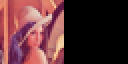

Sample run:


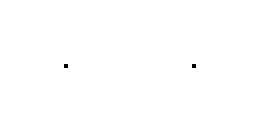

Training...
Stopping due to time-out
Target:


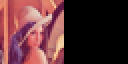

Sample run:


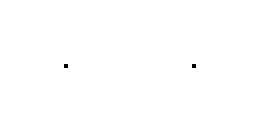


 step: 2, loss: 0.026, log10(loss): -1.583

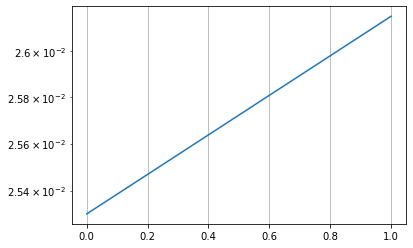

 -- saved parameters
Training...


KeyboardInterrupt: 

In [48]:
import module1
from importlib import reload
import random
reload(module1)

ca = module1.CellularAutomata(
    img_size=32, 
    channel_count=6,
    layer_counts=[1024],
    perception_kernel=module1.sobel_state_kernel())
ca.noise_range = (0, 0) #(-0.1, 0.1)
ca.conserve_mass = False
ca.edge_strategy = module1.EdgeStrategy.MIRROR

lifetime_range = (24,40)

x0 = lambda: ca.pointfilled(ca.constfilled(1.0), point_value=0.0)
xf = lambda: ca.imagefilled("lenna.png")
training = module1.init_training(ca, do_load=True, learning_rate=1.0e-4)
training.show_sample_run(x0, xf, 50)

while not training.is_done():
    print("Training...")
    training.run(x0, xf, random.randrange(*lifetime_range), max_seconds=5)
    training.show_sample_run(x0, xf, 50)
    training.show_loss_history()
    training.save()
    print(" -- saved parameters")